# Sentiment Analysis Classification

This notebook outlines a complete machine learning pipeline for analyzing text sentiment. The workflow is broken down into four main stages:

* **Text Preprocessing:** Cleaning and standardizing the raw text data.
  
* **Feature Extraction:** Converting text into mathematical representations using Bag-of-Words and TF-IDF.

* **Model Evaluation:** Training and comparing the accuracy of Naive Bayes and Logistic Regression classifiers.

* **Visual Diagnostics & Error Analysis:** Visualizing model performance and reviewing misclassified examples to understand model limitations.

## 1. Setup and Imports

In [1]:
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Global configurations
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid")

## 2. Pipeline Architecture

### 2.1. Text Preprocessing

The `preprocess_sentiment` function cleans raw text by stripping platform-specific noise (URLs, mentions), converting emotional punctuations and censored words (e.g. '!', '?', '****') into text tokens, and applying lemmatization. It also features a  negation handler to connect negating modifiers to their subsequent root words (e.g., "not good" becomes "not_good").

In [2]:
# Load spaCy model with parser and NER disabled to optimize processing speed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


# Customize default stop words to retain sentiment-modifying terms
custom_stop_words = nlp.Defaults.stop_words.copy()
exceptions = {"not", "no", "never", "none", "cannot", "but", "however", "down", "up"}
custom_stop_words = nlp.Defaults.stop_words - exceptions


def preprocess_sentiment(text):
    """
    Preprocesses raw text data specifically for sentiment analysis.
    Removes platform-specific noise, preserves critical punctuation
    and profanity as text tokens, applies lemmatization,
    filters custom stop words, and implements sequential negation handling.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove platform-specific noise (URLs, user mentions, hashtag symbols)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'\#', '', text)

    # Preserve sentiment-heavy characters by converting them to text tokens
    text = re.sub(r'\*{2,}', ' censoredswear ', text)
    text = re.sub(r'!+', ' exclamationmark ', text)
    text = re.sub(r'\?+', ' questionmark ', text)

    # Tokenize text
    doc = nlp(text)
    tokens = []

    # Initialize negation tracking flag
    negate_next = False

    for token in doc:
        # Reset negation flag on punctuation and proceed to next token
        if token.is_punct:
            negate_next = False
            continue

        # Filter out whitespace, numbers, and non-alphabetic characters
        if token.is_space or token.like_num or not token.is_alpha:
            continue

        # Extract lemma
        lemma = token.lemma_.strip()

        # Filter tokens using the customized stop word list
        if lemma in custom_stop_words:
            continue

        # Flag the subsequent token for negation prefixing
        if lemma in ["not", "no", "never", "cannot"]:
            negate_next = True
            # Append immediately to preserve if it is the final token
            tokens.append(lemma)
            continue

        # Apply negation prefix by combining with the previous negation term
        if negate_next:
            if tokens:  # Safety check to ensure the token list is not empty
                prev_negation = tokens.pop()
                lemma = f"{prev_negation}_{lemma}"
            negate_next = False

        # Remove exceedingly short tokens unless modified by negation
        if len(lemma) < 2 and "_" not in lemma:
            continue

        tokens.append(lemma)

    return " ".join(tokens)

### 2.2. Feature Extraction

Text data is converted into numerical matrices using Bag-of-Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF).

In [3]:
def extract_bow_features(train_texts, test_texts, max_vocab=5000):
    """
    Extracts Bag-of-Words (BoW) numerical features from preprocessed text.
    Fits strictly on training data to prevent data leakage.

    Args:
        train_texts: Cleaned training strings.
        test_texts: Cleaned testing strings.
        max_vocab: Maximum vocabulary size.

    Returns:
        tuple: (X_train_bow, X_test_bow, bow_vectorizer)
    """
    bow_vectorizer = CountVectorizer(max_features=max_vocab)

    X_train_bow = bow_vectorizer.fit_transform(train_texts)
    X_test_bow = bow_vectorizer.transform(test_texts)

    return X_train_bow, X_test_bow, bow_vectorizer


def extract_tfidf_features(train_texts, test_texts, max_vocab=5000):
    """
    Extracts TF-IDF numerical features from preprocessed text.
    Fits strictly on training data to prevent data leakage.

    Args:
        train_texts: Cleaned training strings.
        test_texts: Cleaned testing strings.
        max_vocab: Maximum vocabulary size.

    Returns:
        tuple: (X_train_tfidf, X_test_tfidf, tfidf_vectorizer)
    """
    tfidf_vectorizer = TfidfVectorizer(max_features=max_vocab)

    X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
    X_test_tfidf = tfidf_vectorizer.transform(test_texts)

    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer

### 2.3. Model Definitions

Two classifiers are defined: Multinomial Naive Bayes and Logistic Regression.

In [4]:
def evaluate_predictions(y_true, y_pred):
    """
    Calculates core classification metrics using weighted averaging
    to account for potential class imbalances in sentiment labels.
    """
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(
            y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(
            y_true, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(
            y_true, y_pred, average='weighted', zero_division=0)
    }


def get_misclassified_examples(
        y_true, y_pred, raw_texts, label_encoder, num_examples=5):
    """
    Identifies and extracts examples where the model's prediction failed.
    """
    errors_df = pd.DataFrame({
        'Text': raw_texts,
        'True_Label': label_encoder.inverse_transform(y_true),
        'Predicted_Label': label_encoder.inverse_transform(y_pred)
    })

    errors_df = errors_df[
        errors_df['True_Label'] != errors_df['Predicted_Label']]

    return errors_df.head(num_examples)


def train_naive_bayes(X_train, y_train, X_test, y_test):
    """
    Trains a Multinomial Naive Bayes classifier and evaluates its performance.
    """
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

    predictions = nb_model.predict(X_test)
    metrics = evaluate_predictions(y_test, predictions)

    return nb_model, metrics, predictions


def train_logistic_regression(X_train, y_train, X_test, y_test, c_value=1.0):
    """
    Trains a Logistic Regression classifier and evaluates its performance.

    Args:
        c_value (float): Inverse of regularization strength.
    """
    lr_model = LogisticRegression(C=c_value, max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)

    predictions = lr_model.predict(X_test)
    metrics = evaluate_predictions(y_test, predictions)

    return lr_model, metrics, predictions

## 3. Pipeline Execution

The datasets are loaded, preprocessed, and executed through the four model-representation combinations. Hyperparameters are tuned for optimal performance on the high-dimensional sparse matrix (`C_VALUE = 10.0`, `VOCAB_LIMIT = 10000`).

### 3.1. Data Loading

In [5]:
# Task 0: DATA LOADING
df_train = pd.read_csv('data/train.csv', encoding='latin-1')
df_test = pd.read_csv('data/test.csv', encoding='latin-1')

# Isolate columns and drop nulls
df_train = df_train[['text', 'sentiment']].dropna(subset=['text'])
df_test = df_test[['text', 'sentiment']].dropna(subset=['text'])

# Enforce string data type for text column
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

display(df_train.head())

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative


### 3.2. Preprocessing Application

In [6]:
# Task 1: PREPROCESSING
df_train['clean_text'] = df_train['text'].apply(preprocess_sentiment)
df_test['clean_text'] = df_test['text'].apply(preprocess_sentiment)

display(df_train[['sentiment', 'text', 'clean_text']].head())

,sentiment,text,clean_text
0,neutral,"I`d have responded, if I were going",respond
1,negative,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego exclamationmark
2,negative,my boss is bullying me...,boss bully
3,negative,what interview! leave me alone,interview exclamationmark leave
4,negative,"Sons of ****, why couldn`t they put them on the releases we already bought",son censoredswear release buy


### 3.3. Feature Matrix Generation

In [7]:
# Task 2: FEATURE EXTRACTION
print("\n--- Feature Extraction Summary ---")
VOCAB_LIMIT = 10000

# Extract Bag-of-Words
X_train_bow, X_test_bow, bow_vec = extract_bow_features(df_train['clean_text'], df_test['clean_text'], max_vocab=VOCAB_LIMIT)
print(f"[BoW] Train Matrix: {X_train_bow.shape[0]} documents x {X_train_bow.shape[1]} features")
print(f"[BoW] Test Matrix:  {X_test_bow.shape[0]} documents x {X_test_bow.shape[1]} features")

# Extract TF-IDF
X_train_tfidf, X_test_tfidf, tfidf_vec = extract_tfidf_features(df_train['clean_text'], df_test['clean_text'], max_vocab=VOCAB_LIMIT)
print(f"[TF-IDF] Train Matrix: {X_train_tfidf.shape[0]} documents x {X_train_tfidf.shape[1]} features")
print(f"[TF-IDF] Test Matrix:  {X_test_tfidf.shape[0]} documents x {X_test_tfidf.shape[1]} features")


--- Feature Extraction Summary ---
[BoW] Train Matrix: 27480 documents x 10000 features
[BoW] Test Matrix:  3534 documents x 10000 features
[TF-IDF] Train Matrix: 27480 documents x 10000 features
[TF-IDF] Test Matrix:  3534 documents x 10000 features


### 3.4. Model Training & Evaluation

In [8]:
# Task 3: MODEL TRAINING AND EVALUATION
C_VALUE = 10.0

# Label Encoding
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment'])
y_test = le.transform(df_test['sentiment'])

# Combination 1: Naive Bayes + BoW
nb_bow_model, nb_bow_metrics, nb_bow_preds = train_naive_bayes(
    X_train_bow, y_train, X_test_bow, y_test
)

# Combination 2: Naive Bayes + TF-IDF
nb_tfidf_model, nb_tfidf_metrics, nb_tfidf_preds = train_naive_bayes(
    X_train_tfidf, y_train, X_test_tfidf, y_test
)

# Combination 3: Logistic Regression + BoW
lr_bow_model, lr_bow_metrics, lr_bow_preds = train_logistic_regression(
    X_train_bow, y_train, X_test_bow, y_test, c_value=C_VALUE
)

# Combination 4: Logistic Regression + TF-IDF
lr_tfidf_model, lr_tfidf_metrics, lr_tfidf_preds = train_logistic_regression(
    X_train_tfidf, y_train, X_test_tfidf, y_test, c_value=C_VALUE
)

# Aggregate metrics into a list of dictionaries for pandas
results_data = [
    {"Model": "Naive Bayes (BoW)", **nb_bow_metrics},
    {"Model": "Naive Bayes (TF-IDF)", **nb_tfidf_metrics},
    {"Model": f"Log Reg (BoW, C={C_VALUE})", **lr_bow_metrics},
    {"Model": f"Log Reg (TF-IDF, C={C_VALUE})", **lr_tfidf_metrics}
]

# Create and display the DataFrame
results_df = pd.DataFrame(results_data)
display(results_df)

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes (BoW),0.686191,0.691411,0.686191,0.687231
1,Naive Bayes (TF-IDF),0.658461,0.686960,0.658461,0.656941
2,"Log Reg (BoW, C=10.0)",0.687040,0.690923,0.687040,0.688052
3,"Log Reg (TF-IDF, C=10.0)",0.692417,0.696743,0.692417,0.693523


## 4. Visual Diagnostics & Error Analysis

### 4.1. Performance Comparison

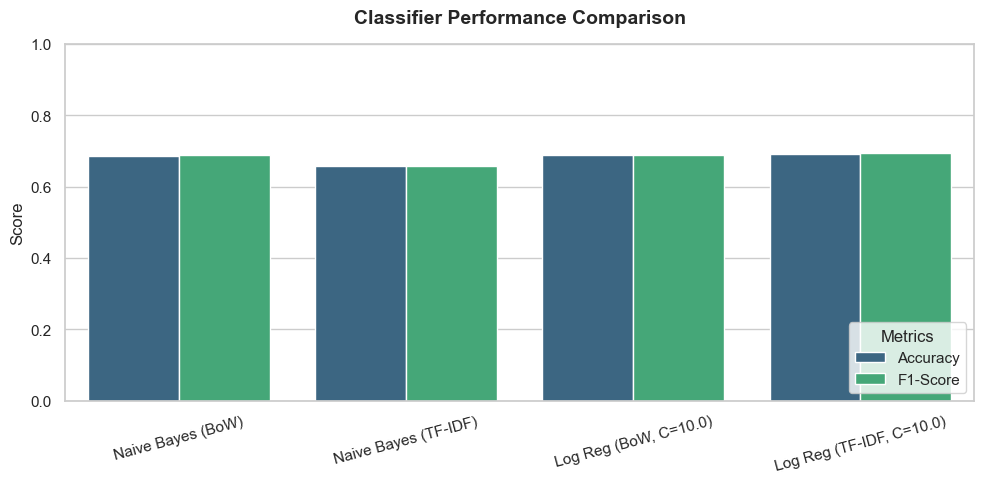

In [9]:
df_filtered = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
df_filtered = df_filtered[df_filtered["Metric"].isin(["Accuracy", "F1-Score"])]

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=df_filtered, palette="viridis")
plt.title("Classifier Performance Comparison", fontsize=14, fontweight='bold', pad=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=15)
plt.legend(loc='lower right', title="Metrics")
plt.tight_layout()
plt.show()

### 4.2. Confusion Matrix (Log Reg + TF-IDF)

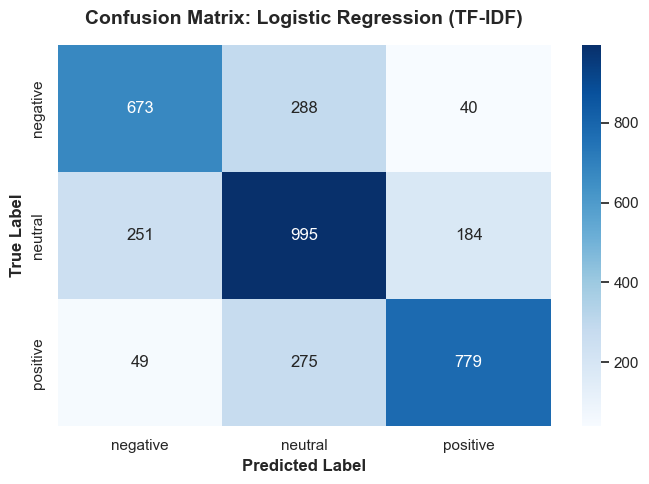

In [10]:
cm = confusion_matrix(y_test, lr_tfidf_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 12})
plt.title("Confusion Matrix: Logistic Regression (TF-IDF)", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("True Label", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3. Feature Importance (Log Reg + TF-IDF)

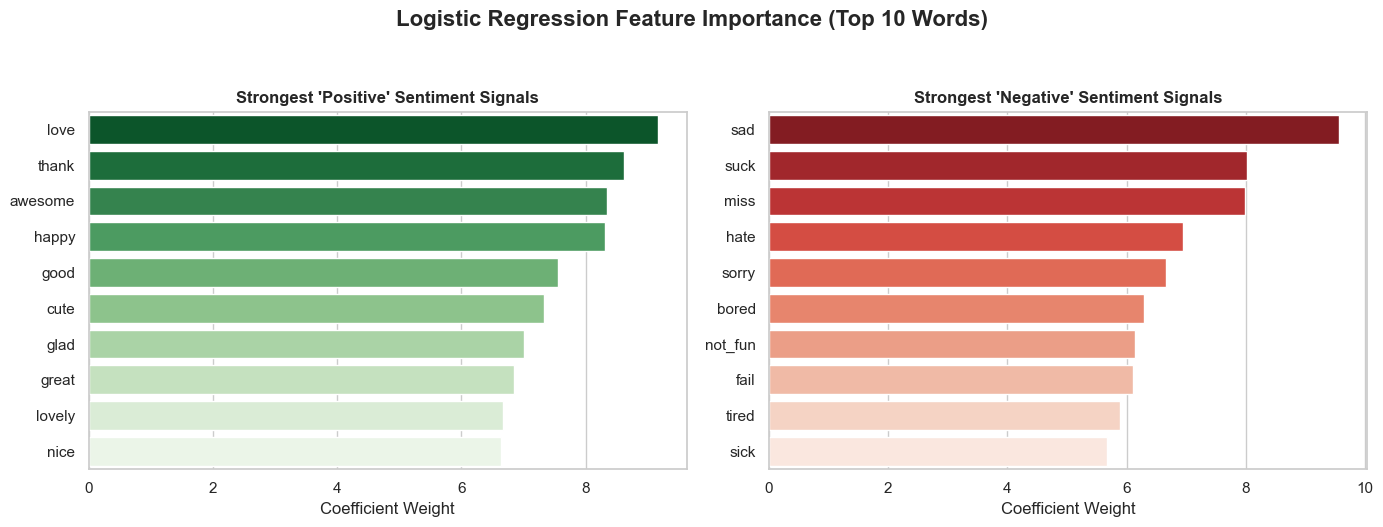

In [11]:
feature_names = tfidf_vec.get_feature_names_out()
pos_idx = list(le.classes_).index('positive')
neg_idx = list(le.classes_).index('negative')

pos_coefficients = lr_tfidf_model.coef_[pos_idx]
neg_coefficients = lr_tfidf_model.coef_[neg_idx]

top_pos_indices = pos_coefficients.argsort()[-10:][::-1]
top_neg_indices = neg_coefficients.argsort()[-10:][::-1]

pos_words = [feature_names[i] for i in top_pos_indices]
neg_words = [feature_names[i] for i in top_neg_indices]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(
    x=pos_coefficients[top_pos_indices], 
    y=pos_words, 
    hue=pos_words, 
    ax=axes[0], 
    palette="Greens_r",
    legend=False
)
axes[0].set_title("Strongest 'Positive' Sentiment Signals", fontweight='bold')
axes[0].set_xlabel("Coefficient Weight")

sns.barplot(
    x=neg_coefficients[top_neg_indices], 
    y=neg_words, 
    hue=neg_words, 
    ax=axes[1], 
    palette="Reds_r",
    legend=False
)
axes[1].set_title("Strongest 'Negative' Sentiment Signals", fontweight='bold')
axes[1].set_xlabel("Coefficient Weight")

plt.suptitle("Logistic Regression Feature Importance (Top 10 Words)", fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 4.4. Qualitative Error Analysis (Log Reg + TF-IDF)

In [12]:
# Retrieve 20 examples where the model's prediction doesn't match the true label
misclassified_df = get_misclassified_examples(
    y_true=y_test,
    y_pred=lr_tfidf_preds,
    raw_texts=df_test['text'],
    label_encoder=le,
    num_examples=20
)

display(misclassified_df)

,Text,True_Label,Predicted_Label
12,.. and you`re on twitter! Did the tavern bore you that much?,neutral,negative
28,look who I found just for you ---> http://twitter.com/DJT2009,positive,neutral
31,resorted to eating Mickey Ds ALONE.,neutral,positive
32,"There is a faux gothy chick looking at me, sorry I am not going to camden and I like pop-punk and jimmy eat world",neutral,negative
37,So I really need to put the laptop down & start getting ready for shindig...But I`ve missed my TwitterLoves all day,neutral,negative
40,4n? ma rog never heard of it esti beat acum? u tweet too much,negative,neutral
46,i miss my old phone it worked so good until i dropped it i want a new one for my birthday...,neutral,negative
64,at starbucks with my love. eff school. i have work later too.,neutral,positive
68,"for...the...loss. dumbface ...him, not u. what u up to on the wknd? i wanna seeeeeee ya!",negative,positive
72,TGIF is right...I think I broke my toe last night - on my bad foot.,neutral,negative
